**EE219 Winter 2019, Project 2**

In [23]:
# setting the random seed
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups

np.random.seed(42)
random.seed(42)

In [24]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.base import BaseEstimator, TransformerMixin
import re
# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')

In [25]:
# Set the global directory to place figs in project:
figs_dir = 'figs'

import os
if not os.path.exists(figs_dir):
    os.mkdir(figs_dir)

In [26]:
# Fetching 20NewsGroups dataset

categories = ['comp.sys.ibm.pc.hardware', 'comp.graphics', 'comp.sys.mac.hardware', 
              'comp.os.ms-windows.misc', 'rec.autos', 'rec.motorcycles', 
              'rec.sport.baseball', 'rec.sport.hockey']

twenty_data = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)


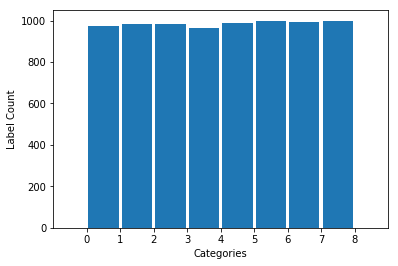

In [27]:
# Fetch all 8 news groups categories and plot a histogram of the training documents.

x = range(-1,23)
plt.hist(twenty_data.target, x, rwidth=0.9)
plt.xlabel('Categories')
plt.ylabel('Label Count')
plt.xticks(np.arange(9, step=1))
plt.xlim(left=-1, right = 9)
plt.savefig('{}/8-groups.eps'.format(figs_dir), format='eps', dpi=100)
plt.show()

In [28]:
# Change labels into binary based on two well separated classes: Class 1 (labels 0-3) and Class 2 (labels 4-7).
twenty_binary_labels = np.zeros(len(twenty_data.target))
for k in range(len(twenty_data.target)):
    if twenty_data.target[k] >= 4:
        twenty_binary_labels[k] = 1
    else:
        twenty_binary_labels[k] = 0
            
class_names = ['Class 1', 'Class 2']

**Question 1**

In [29]:
# Push documents through CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()

count_vect = CountVectorizer(min_df=3, stop_words='english')

# do for the whole set
X_data = count_vect.fit_transform(twenty_data.data)

In [30]:
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# do for training
X_data_tfidf = tfidf_transformer.fit_transform(X_data)
print('Dimensions of the TF-IDF matrix are: {}'.format(X_data_tfidf.shape))

Dimensions of the TF-IDF matrix are: (7882, 27768)


**Question 2**

In [31]:
# Applying k-means clustering
# data is called X_data_tfidf
from sklearn.cluster import KMeans

#reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

#perfroming kmeans clsutering with k=2
kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1001, n_init = 40).fit(X_data_tfidf)


**Question 2(a)**

In [32]:
# Contingency matrix
from sklearn.metrics.cluster import contingency_matrix

contingency_matrix(twenty_binary_labels, kmeans.labels_)


array([[   4, 3899],
       [1718, 2261]])

**Question 2(b)**

In [33]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

homogeneity = homogeneity_score(twenty_binary_labels, kmeans.labels_)
completeness = completeness_score(twenty_binary_labels, kmeans.labels_)
v_measure = v_measure_score(twenty_binary_labels, kmeans.labels_)
adjusted_rand_index = adjusted_rand_score(twenty_binary_labels, kmeans.labels_)
adjusted_mutual_info = adjusted_mutual_info_score(twenty_binary_labels, kmeans.labels_)

print('kmeans clustering results with k=2')
print('-------------------------------------------------------------------')
print('Homegeneity: {}'.format(homogeneity))
print('Completeness: {}'.format(completeness))
print('V-measure: {}'.format(v_measure))
print('Adjusted Rand Index: {}'.format(adjusted_rand_index))
print('Adjusted Mutual Information Score: {}'.format(adjusted_mutual_info))
print('-------------------------------------------------------------------')


kmeans clustering results with k=2
-------------------------------------------------------------------
Homegeneity: 0.2535958928926043
Completeness: 0.334815748824373
V-measure: 0.28860033608397917
Adjusted Rand Index: 0.18076179588914554
Adjusted Mutual Information Score: 0.25352755133060884
-------------------------------------------------------------------


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


#### Question 4

In [34]:
# Perform SVD on the TF-IDF matrix
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, random_state=42)
X_data_svd = svd.fit_transform(X_data_tfidf)

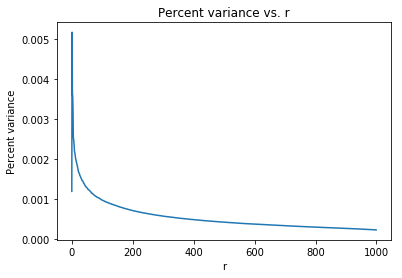

In [35]:
# Plot variance ratios

variances = svd.explained_variance_ratio_

plt.figure()
plt.plot(np.cumsum(variances))
plt.title('Percent variance vs. r')
plt.xlabel('r')
plt.ylabel('Percent variance')
plt.show()

#### Question 5

In [36]:
# Initialize r, which is basically how many components we want to use.

r = [1, 2, 3, 5, 10, 20, 50, 100, 300]

In [37]:
# SVD

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=300)
X_data_svd_r = svd.fit_transform(X_data_tfidf)

In [38]:
# Import packages

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [39]:
svd_homogeneity = np.zeros(len(r))
svd_completeness = np.zeros(len(r))
svd_v = np.zeros(len(r))
svd_rand = np.zeros(len(r))
svd_mutual_info = np.zeros(len(r))

# svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40)
for i in range(len(r)):
    svd_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_svd_r.T[0:r[i]].T)
    svd_homogeneity[i] = homogeneity_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_completeness[i] = completeness_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_v[i] = v_measure_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_rand[i] = adjusted_rand_score(twenty_binary_labels, svd_kmeans.labels_)
    svd_mutual_info[i] = adjusted_mutual_info_score(twenty_binary_labels, svd_kmeans.labels_)
    

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: Future

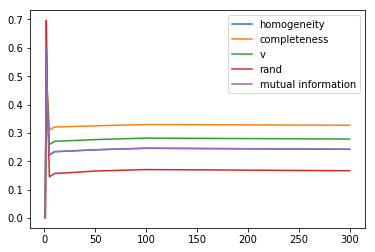

In [40]:
# Plot metrics for svd.

plt.figure()
plt.plot(r, svd_homogeneity)
plt.plot(r, svd_completeness)
plt.plot(r, svd_v)
plt.plot(r, svd_rand)
plt.plot(r, svd_mutual_info)

plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

In [41]:
print('Homogeneity scores: ', np.round(svd_homogeneity, 4))
print('Completeness scores: ', np.round(svd_completeness, 4))
print('V measure scores: ', np.round(svd_v, 4))
print('Adjusted rand scores: ', np.round(svd_rand, 4))
print('Adjusted mutual information scores: ', np.round(svd_mutual_info, 4))

Homogeneity scores:  [3.000e-04 5.959e-01 4.164e-01 2.217e-01 2.339e-01 2.353e-01 2.405e-01
 2.459e-01 2.423e-01]
Completeness scores:  [3.000e-04 5.970e-01 4.506e-01 3.100e-01 3.207e-01 3.218e-01 3.249e-01
 3.297e-01 3.270e-01]
V measure scores:  [3.000e-04 5.965e-01 4.329e-01 2.585e-01 2.705e-01 2.718e-01 2.765e-01
 2.817e-01 2.784e-01]
Adjusted rand scores:  [3.000e-04 6.973e-01 4.199e-01 1.452e-01 1.570e-01 1.586e-01 1.656e-01
 1.708e-01 1.666e-01]
Adjusted mutual information scores:  [2.000e-04 5.959e-01 4.164e-01 2.216e-01 2.338e-01 2.353e-01 2.405e-01
 2.458e-01 2.422e-01]


In [42]:
# Import packages

from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [43]:
# Initialize r and each an array for each metric.

r = [1, 2, 3, 5, 10, 20, 50, 100, 300]

nmf_homogeneity = np.zeros(len(r))
nmf_completeness = np.zeros(len(r))
nmf_v = np.zeros(len(r))
nmf_rand = np.zeros(len(r))
nmf_mutual_info = np.zeros(len(r))

In [44]:
# Perform NMF for each number of components and calculate each metric

for i in range(len(r)):
    nmf = NMF(n_components=r[i])
    X_data_nmf_r = nmf.fit_transform(X_data_tfidf)
    nmf_kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=40).fit(X_data_nmf_r)
    nmf_homogeneity[i] = homogeneity_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_completeness[i] = completeness_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_v[i] = v_measure_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_rand[i] = adjusted_rand_score(twenty_binary_labels, nmf_kmeans.labels_)
    nmf_mutual_info[i] = adjusted_mutual_info_score(twenty_binary_labels, nmf_kmeans.labels_)

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: Future

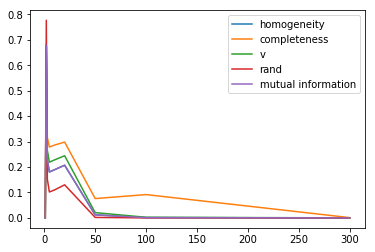

In [45]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r, nmf_homogeneity)
plt.plot(r, nmf_completeness)
plt.plot(r, nmf_v)
plt.plot(r, nmf_rand)
plt.plot(r, nmf_mutual_info)

plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

In [46]:
print('Homogeneity scores: ', np.round(nmf_homogeneity, 4))
print('Completeness scores: ', np.round(nmf_completeness, 4))
print('V measure scores: ', np.round(nmf_v, 4))
print('Adjusted rand scores: ', np.round(nmf_rand, 4))
print('Adjusted mutual information scores: ', np.round(nmf_mutual_info, 4))

Homogeneity scores:  [3.000e-04 6.790e-01 2.293e-01 1.806e-01 1.893e-01 2.071e-01 1.210e-02
 1.300e-03 1.000e-04]
Completeness scores:  [3.000e-04 6.801e-01 3.165e-01 2.787e-01 2.862e-01 2.982e-01 7.610e-02
 9.170e-02 1.200e-03]
V measure scores:  [3.000e-04 6.796e-01 2.660e-01 2.192e-01 2.279e-01 2.444e-01 2.080e-02
 2.500e-03 2.000e-04]
Adjusted rand scores:  [3.000e-04 7.770e-01 1.528e-01 1.020e-01 1.099e-01 1.301e-01 2.000e-03
 1.000e-04 1.000e-04]
Adjusted mutual information scores:  [2.000e-04 6.790e-01 2.293e-01 1.806e-01 1.893e-01 2.071e-01 1.200e-02
 1.200e-03 0.000e+00]


#### Question 6

<span style='color:red'>TODO</span>

Both the SVD and NMF measures have non-monotonic behaviors as r increases.

#### Question 11

##### Pull in the 20-category dataset

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\matplotlib\axes\_base.py:3116: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\matplotlib\axes\_base.py:3122: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


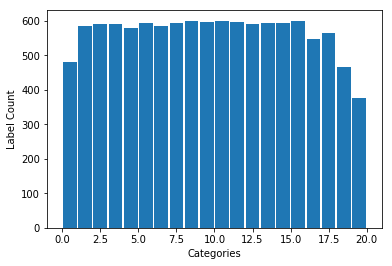

20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [79]:
# Fetch all 20 news groups categories and plot a histogram of the training documents.

twenty_data20 = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
x = range(-1,23)
plt.hist(newsgroups_train.target, x, rwidth=0.9)
plt.xlabel('Categories')
plt.ylabel('Label Count')
plt.xlim(xmin=-1, xmax = 21)
plt.savefig('{}/20-groups.eps'.format(figs_dir), format='eps', dpi=100)
plt.show()

categories = twenty_data20.target_names
print(len(categories)) # there should be 20
print(categories)

##### Redo CountVect and TF-IDF calculations

In [80]:
# Push documents through CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()

count_vect20 = CountVectorizer(min_df=3, stop_words='english')

# do for the whole set
X_data20 = count_vect20.fit_transform(twenty_data20.data)

In [81]:
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer20 = TfidfTransformer()

# do for training
X_data_tfidf20 = tfidf_transformer20.fit_transform(X_data20)
print('Dimensions of the TF-IDF matrix are: {}'.format(X_data_tfidf20.shape))

Dimensions of the TF-IDF matrix are: (11314, 38563)


##### Applying K-means

In [83]:
# Applying k-means clustering
# data is called X_data_tfidf
from sklearn.cluster import KMeans
import time

#reference: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

#perfroming kmeans clsutering with k=20
start_time = time.time()
kmeans20 = KMeans(n_clusters=20, random_state=0, max_iter=1000, n_init = 40, n_jobs=-1).fit(X_data_tfidf20)
print('Time taken for kmean 20-class clustering: {:.2f} minutes'.format((time.time() - start_time)/60))
      
kmeans_labels= kmeans20.labels_
category_labels = twenty_data20.target

Time taken for kmean 20-class clustering: 36.74 minutes


#### Report the 5 measures:

In [84]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

homogeneity = homogeneity_score(category_labels, kmeans_labels)
completeness = completeness_score(category_labels, kmeans_labels)
v_measure = v_measure_score(category_labels, kmeans_labels)
adjusted_rand_index = adjusted_rand_score(category_labels, kmeans_labels)
adjusted_mutual_info = adjusted_mutual_info_score(category_labels, kmeans_labels)

print('kmeans clustering results with k=20')
print('-------------------------------------------------------------------')
print('Homegeneity: {}'.format(homogeneity))
print('Completeness: {}'.format(completeness))
print('V-measure: {}'.format(v_measure))
print('Adjusted Rand Index: {}'.format(adjusted_rand_index))
print('Adjusted Mutual Information Score: {}'.format(adjusted_mutual_info))
print('-------------------------------------------------------------------')

kmeans clustering results with k=20
-------------------------------------------------------------------
Homegeneity: 0.30858035934907474
Completeness: 0.3910795121229359
V-measure: 0.3449660650997735
Adjusted Rand Index: 0.11048329289056244
Adjusted Mutual Information Score: 0.3047922979115795
-------------------------------------------------------------------


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


##### and the contingency matrix:

In [85]:
# Contingency matrix
from sklearn.metrics.cluster import contingency_matrix

contingency_matrix(category_labels, kmeans_labels)

array([[  0,   0,   0, 113, 138,   0,  14,   0,   0,   6,  35, 130,  39,
          0,   0,   1,   0,   4,   0,   0],
       [  0,   0,   0,   1,  58, 129,  11,   0,   0,  18,  49,   4, 298,
          1,   2,   9,   4,   0,   0,   0],
       [  4,   0,   0,   0,  25, 341,  10,   0,   0,  15,  27,   5, 146,
         12,   0,   1,   5,   0,   0,   0],
       [123,   0,   0,   0,  75, 133,   6,   0,   0,  14,  12,  18, 185,
          6,   0,   5,  11,   0,   2,   0],
       [ 46,   0,   0,   0,  62,  40,  10,   0,   0,  12,  17,  18, 345,
          1,   7,   7,  13,   0,   0,   0],
       [  0,   2,   0,   0,  94, 113,   1,   0,   0,  10,  60,   2, 292,
          0,   2,  15,   2,   0,   0,   0],
       [ 19,   0,   0,   0,  92,  36,   5,   0,   0,   9,   3,   7, 359,
          7,  20,   2,  16,   0,  10,   0],
       [  0,   0,   0,   0, 378,   3,  35,   0,   0,  22,   5,  12, 109,
          0,  21,   1,   5,   2,   0,   1],
       [  0,   0,   0,   0, 332,   0,  18,   0,   0,  80,  60,  

#### Question 12

##### Analyzing SVD:

In [ ]:
# Initialize r, which is basically how many components we want to use.

r20 = [1, 2, 3, 5, 10, 20, 50, 100, 300]

In [ ]:
# SVD

from sklearn.decomposition import TruncatedSVD

svd20 = TruncatedSVD(n_components=r20[-1])
X_data_svd_r20 = svd20.fit_transform(X_data_tfidf20)

In [ ]:
# Import packages

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [ ]:
svd_homogeneity = np.zeros(len(r20))
svd_completeness = np.zeros(len(r20))
svd_v = np.zeros(len(r20))
svd_rand = np.zeros(len(r20))
svd_mutual_info = np.zeros(len(r20))

category_labels = twenty_data20.target

import time
start_time = time.time()

for i in range(len(r20)):
    svd_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=2000, n_init=100, n_jobs=-1).fit(X_data_svd_r20[:, 0:r20[i]])
    svd_homogeneity[i] = homogeneity_score(category_labels, svd_kmeans.labels_)
    svd_completeness[i] = completeness_score(category_labels, svd_kmeans.labels_)
    svd_v[i] = v_measure_score(category_labels, svd_kmeans.labels_)
    svd_rand[i] = adjusted_rand_score(category_labels, svd_kmeans.labels_)
    svd_mutual_info[i] = adjusted_mutual_info_score(category_labels, svd_kmeans.labels_)
    print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - start_time)/60)
    
print('Time taken for kmean 20-class SVD search: {:.2f} minutes'.format((time.time() - start_time)/60))

In [ ]:
# Plot metrics for svd.

plt.figure()
plt.plot(r, svd_homogeneity)
plt.plot(r, svd_completeness)
plt.plot(r, svd_v)
plt.plot(r, svd_rand)
plt.plot(r, svd_mutual_info)

plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

In [ ]:
print('Homogeneity scores: ', np.round(svd_homogeneity, 4))
print('Completeness scores: ', np.round(svd_completeness, 4))
print('V measure scores: ', np.round(svd_v, 4))
print('Adjusted rand scores: ', np.round(svd_rand, 4))
print('Adjusted mutual information scores: ', np.round(svd_mutual_info, 4))

##### Analyzing NMF:

In [ ]:
# Import packages

from sklearn.decomposition import NMF

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score

In [ ]:
# Initialize an array for each metric.

nmf_homogeneity = np.zeros(len(r20))
nmf_completeness = np.zeros(len(r20))
nmf_v = np.zeros(len(r20))
nmf_rand = np.zeros(len(r20))
nmf_mutual_info = np.zeros(len(r20))

In [ ]:
# Perform NMF for each number of components and calculate each metric

category_labels = twenty_data20.target

import time
start_time = time.time()

for i in range(len(r20)):
    nmf = NMF(n_components=r20[i])
    X_data_nmf_r = nmf.fit_transform(X_data_tfidf20)
    nmf_kmeans = KMeans(n_clusters=20, random_state=0, max_iter=2000, n_init=100, n_jobs=-1).fit(X_data_nmf_r)
    nmf_homogeneity[i] = homogeneity_score(category_labels, nmf_kmeans.labels_)
    nmf_completeness[i] = completeness_score(category_labels, nmf_kmeans.labels_)
    nmf_v[i] = v_measure_score(category_labels, nmf_kmeans.labels_)
    nmf_rand[i] = adjusted_rand_score(category_labels, nmf_kmeans.labels_)
    nmf_mutual_info[i] = adjusted_mutual_info_score(category_labels, nmf_kmeans.labels_)
    print('r={}: {:.2f} minutes'.format(r20[i], (time.time() - start_time)/60)
    
print('Time taken for kmean 20-class NMF search: {:.2f} minutes'.format((time.time() - start_time)/60))

In [ ]:
# Plot metrics for nmf.

plt.figure()
plt.plot(r, nmf_homogeneity)
plt.plot(r, nmf_completeness)
plt.plot(r, nmf_v)
plt.plot(r, nmf_rand)
plt.plot(r, nmf_mutual_info)

plt.legend(['homogeneity', 'completeness', 'v', 'rand', 'mutual information'])
plt.show()

In [ ]:
print('Homogeneity scores: ', np.round(nmf_homogeneity, 4))
print('Completeness scores: ', np.round(nmf_completeness, 4))
print('V measure scores: ', np.round(nmf_v, 4))
print('Adjusted rand scores: ', np.round(nmf_rand, 4))
print('Adjusted mutual information scores: ', np.round(nmf_mutual_info, 4))